In [1]:
import pandas as pd

In [2]:
# Load dataset

from tdc.multi_pred import PeptideMHC
data = PeptideMHC(name = 'MHC1_IEDB-IMGT_Nielsen')
split = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
template = """### Instructions: Answer the following question about peptide-MHC binding. 
### Context: In the human body, T cells monitor the existing peptides and trigger an immune response if the peptide is foreign. To decide whether or not if the peptide is not foreign, the peptide must bind to a major histocompatibility complex (MHC) molecule. Therefore, 
predicting peptide-MHC binding affinity is pivotal for determining immunogenicity. In some experiments, the peptide 
binding is measured against cells that express multiple MHCs, so the peptide could be binding any one of the possible MHCs. 
Class 1 MHC molecules bind to peptides that are usually 8-14 amino acids long and activate CD8 T cells. 
### Question: Given the amino acid sequence of the peptide and possible pseudo amino acid sequences of MHC 1, predict whether the peptide 
(A) does not bind to any of the MHCs (B) binds to any of the MHCs 
Peptide amino acid sequence: {}
Possible MHC pseudosequences: {} 
### Answer: {}"""


In [4]:
split["train"].head()

,Peptide_ID,Peptide,MHC_ID,MHC,Y
0,1,ASYAAAAAY,BoLA-D18.4,YYSEYREISENVYESNLYIAYSDYTWEYLNYRWY,0.496594
1,2,GMMGGLWKY,BoLA-D18.4,YYSEYREISENVYESNLYIAYSDYTWEYLNYRWY,0.439136
2,3,KMFHGGLRY,BoLA-D18.4,YYSEYREISENVYESNLYIAYSDYTWEYLNYRWY,0.898463
3,4,KMLEASTIY,BoLA-D18.4,YYSEYREISENVYESNLYIAYSDYTWEYLNYRWY,0.756090
4,5,KQLEYSWVL,BoLA-D18.4,YYSEYREISENVYESNLYIAYSDYTWEYLNYRWY,0.481554


<Axes: ylabel='Y'>

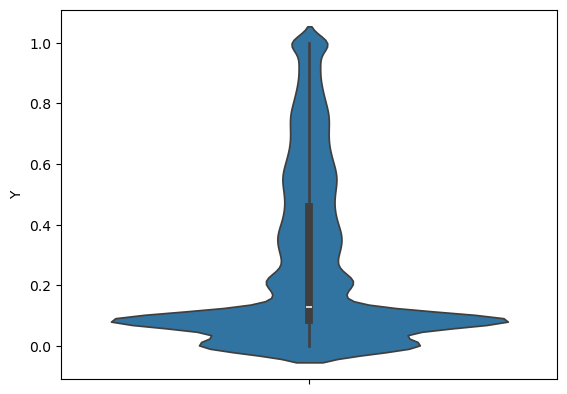

In [5]:
import seaborn as sns

sns.violinplot(split["train"]["Y"])

In [8]:
split["train"]["Y"].quantile(0.70)

0.380319

In [9]:
split["train"]["Y"] = (split["train"]["Y"]<0.380319).astype(int)
split["valid"]["Y"] = (split["valid"]["Y"]<0.380319).astype(int)
split["test"]["Y"] = (split["test"]["Y"]<0.380319).astype(int)

In [11]:
# process dataset

def formatting_prompts_func(examples):
    peptide = examples["Peptide"]
    mhc = examples["MHC"]
    outputs       = examples["Y"]
    token_sizes = []
    texts = []
    for p,m,o in zip(peptide, mhc, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "(B)" if o else "(A)")
        texts.append(text)
        token_sizes.append(len(text))
    return { "text" : texts, "peptide":peptide, "mhc":mhc, "outputs":outputs, "token_size":token_sizes, "ds_ident":"PeptideMHC_MHC1_IEDB-IMGT_Nielsen"}

def formatting_prompts_func_test(examples):
    peptide = examples["Peptide"]
    mhc = examples["MHC"]
    outputs       = examples["Y"]
    token_sizes = []
    texts = []
    for p,m,o in zip(peptide, mhc, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "")
        texts.append(text)
        token_sizes.append(len(text))
    return { "text" : texts, "peptide":peptide, "mhc":mhc, "outputs":outputs, "token_size":token_sizes, "ds_ident":"PeptideMHC_MHC1_IEDB-IMGT_Nielsen"}

In [12]:
train_dataset = formatting_prompts_func(split["train"])
valid_dataset = formatting_prompts_func_test(split["valid"])
test_dataset = formatting_prompts_func_test(split["test"])

In [13]:
len(train_dataset["text"]), len(valid_dataset["text"]), len(test_dataset["text"])

(130190, 18598, 37197)

<Axes: >

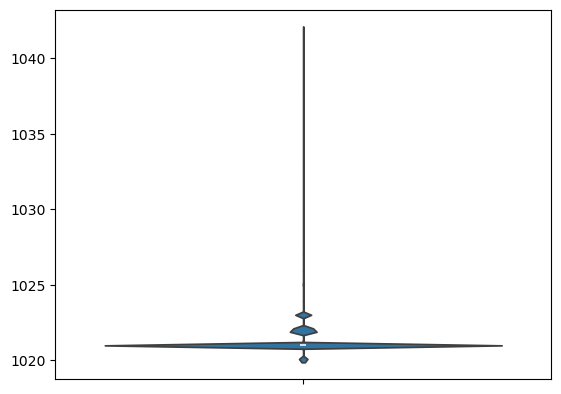

In [14]:
import seaborn as sns

sns.violinplot(train_dataset["token_size"])

In [15]:
import pickle
import os


def dump_file(obj, path, file_name):
    os.makedirs(path, exist_ok=True)
    file_name = os.path.join(path,file_name)
    with open(file_name, "wb") as f0:
        pickle.dump(obj,f0)

In [16]:
dump_file(train_dataset, "processed", "train.pkl")
dump_file(valid_dataset, "processed", "valid.pkl")
dump_file(test_dataset, "processed", "test.pkl")